# Practice Lab: Neural Networks for Handwritten Digit Recognition, Binary

In this exercise, you will use a neural network to recognize the hand-written digits zero and one.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Neural Networks](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2 Dataset](#2.2)
  - [ 2.3 Model representation](#2.3)
  - [ 2.4 Tensorflow Model Implementation](#2.4)
    - [ Exercise 1](#ex01)
  - [ 2.5 NumPy Model Implementation (Forward Prop in NumPy)](#2.5)
    - [ Exercise 2](#ex02)
  - [ 2.6 Vectorized NumPy Model Implementation (Optional)](#2.6)
    - [ Exercise 3](#ex03)
  - [ 2.7 Congratulations!](#2.7)
  - [ 2.8 NumPy Broadcasting Tutorial (Optional)](#2.8)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

**Tensorflow and Keras**  
Tensorflow is a machine learning package developed by Google. In 2019, Google integrated Keras into Tensorflow and released Tensorflow 2.0. Keras is a framework developed independently by François Chollet that creates a simple, layer-centric interface to Tensorflow. This course will be using the Keras interface. 

<a name="2"></a>
## 2 - Neural Networks

In Course 1, you implemented logistic regression. This was extended to handle non-linear boundaries using polynomial regression. For even more complex scenarios such as image recognition, neural networks are preferred.

<a name="2.1"></a>
### 2.1 Problem Statement

In this exercise, you will use a neural network to recognize two handwritten digits, zero and one. This is a binary classification task. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. You will extend this network to recognize all 10 digits (0-9) in a future assignment. 

This exercise will show you how the methods you have learned can be used for this classification task.

<a name="2.2"></a>
### 2.2 Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [2]:
# load dataset
X, y = load_data()

<a name="toc_89367_2.2.1"></a>
#### 2.2.1 View the variables
Let's get more familiar with your dataset.  
- A good place to start is to print out each variable and see what it contains.

The code below prints elements of the variables `X` and `y`.  

In [4]:
print ('The first element of X is: ', X[0].shape)

The first element of X is:  (400,)


In [9]:
print ('The first element of y is: ', y[0])
print ('The last element of y is: ', y[-1])


The first element of y is:  [0]
The last element of y is:  [1]


<a name="toc_89367_2.2.2"></a>
#### 2.2.2 Check the dimensions of your variables

Another way to get familiar with your data is to view its dimensions. Please print the shape of `X` and `y` and see how many training examples you have in your dataset.

In [10]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


<a name="toc_89367_2.2.3"></a>
#### 2.2.3 Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

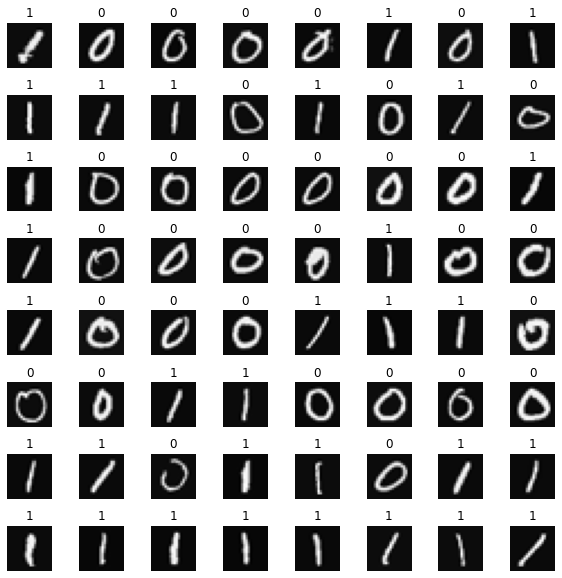

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

<a name="2.3"></a>
### 2.3 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="images/C2_W1_Assign1.PNG" width="500" height="400">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 
               

<a name="2.4"></a>
### 2.4 Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statment below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

<a name="ex01"></a>
### Exercise 1

Below, using Keras [Sequential model](https://keras.io/guides/sequential_model/) and [Dense Layer](https://keras.io/api/layers/core_layers/dense/) with a sigmoid activation to construct the network described above.

In [17]:
# UNQ_C1
# GRADED CELL: Sequential model

model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),    #specify input size
        ### START CODE HERE ### 
        Dense(25, activation='sigmoid', name = 'layer1'),
        Dense(15, activation='sigmoid', name = 'layer2'),
        Dense(1, activation='sigmoid', name = 'layer3'),     
        ### END CODE HERE ### 
    ], name = "my_model" 
)                            


In [18]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


<details>
  <summary><font size="3" color="darkgreen"><b>Expected Output (Click to Expand) </b></font></summary>
The `model.summary()` function displays a useful summary of the model. Because we have specified an input layer size, the shape of the weight and bias arrays are determined and the total number of parameters per layer can be shown. Note, the names of the layers may vary as they are auto-generated.  
    
    
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 25)                10025     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
=================================================================
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________
```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
As described in the lecture:
    
```python
model = Sequential(                      
    [                                   
        tf.keras.Input(shape=(400,)),    # specify input size (optional)
        Dense(25, activation='sigmoid'), 
        Dense(15, activation='sigmoid'), 
        Dense(1,  activation='sigmoid')  
    ], name = "my_model"                                    
)                                       
``` 

In [19]:
# UNIT TESTS
from public_tests import * 

test_c1(model)

All tests passed!


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [ ]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [20]:
[layer1, layer2, layer3] = model.layers

In [21]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


**Expected Output**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 1), b3 shape = (1,)
```

`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [22]:
print(model.layers[2].weights)

[<tf.Variable 'layer3/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[-0.01378292],
       [ 0.34952343],
       [-0.25775012],
       [ 0.08579922],
       [ 0.06114739],
       [ 0.17652422],
       [ 0.44458956],
       [-0.5572968 ],
       [-0.02543032],
       [-0.00852734],
       [-0.572365  ],
       [-0.5733683 ],
       [-0.07991028],
       [ 0.37764406],
       [ 0.26232606]], dtype=float32)>, <tf.Variable 'layer3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


The following code will define a loss function and run gradient descent to fit the weights of the model to the training data. This will be explained in more detail in the following week.

In [23]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X,y,
    epochs=20
)

Epoch 1/20
32/32 [==============================] - 0s 1ms/step - loss: 0.5967
Epoch 2/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.2983
Epoch 4/20
32/32 [==============================] - 0s 1ms/step - loss: 0.2075
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1496
Epoch 6/20
32/32 [==============================] - 0s 1ms/step - loss: 0.1132
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 8/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0731
Epoch 9/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0611
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 11/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 12/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0403
Epoch 13/20
32/32 [==============================

To run the model on an example to make a prediction, use [Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model). The input to `predict` is an array so the single example is reshaped to be two dimensional.

In [24]:
prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")

 predicting a zero: [[0.01583335]]
 predicting a one:  [[0.9855946]]


The output of the model is interpreted as a probability. In the first example above, the input is a zero. The model predicts the probability that the input is a one is nearly zero. 
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [25]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

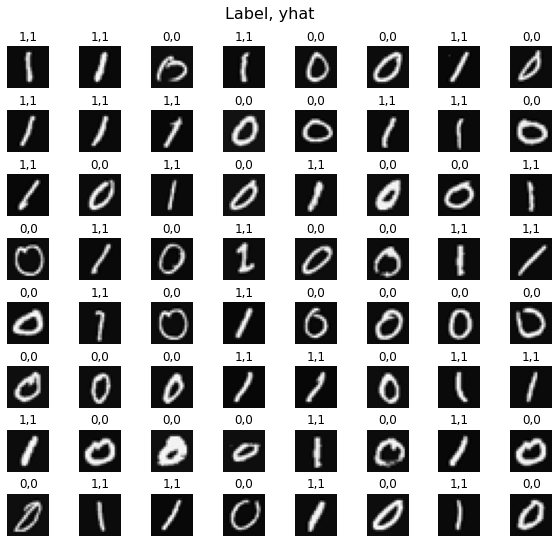

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

<a name="2.5"></a>
### 2.5 NumPy Model Implementation (Forward Prop in NumPy)
As described in lecture, it is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

<img src="images/C2_W1_dense2.PNG" width="600" height="450">


<a name="ex02"></a>
### Exercise 2

Below, build a dense layer subroutine. The example in lecture utilized a for loop to visit each unit (`j`) in the layer and perform the dot product of the weights for that unit (`W[:,j]`) and sum the bias for the unit (`b[j]`) to form `z`. An activation function `g(z)` is then applied to that result. This section will not utilize some of the matrix operations described in the optional lectures. These will be explored in a later section.

In [27]:
# UNQ_C2
# GRADED FUNCTION: my_dense

def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w = W[:,j]                     
        z = np.dot(w, a_in) + b[j]     
        a_out[j] = g(z)                
    return(a_out)


In [32]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)
W_tst

[0.54735762 0.57932425 0.61063923]


array([[0.1, 0.2, 0.3],
       [0.4, 0.5, 0.6]])

**Expected Output**
```
[0.54735762 0.57932425 0.61063923]
```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
As described in the lecture:
    
```python
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w =                            # Select weights for unit j. These are in column j of W
        z =                            # dot product of w and a_in + b
        a_out[j] =                     # apply activation to z
    return(a_out)
```
   
    
<details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>

    
```python
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w = W[:,j]                     
        z = np.dot(w, a_in) + b[j]     
        a_out[j] = g(z)                
    return(a_out)
``` 

In [33]:
# UNIT TESTS
test_c2(my_dense)

All tests passed!


The following cell builds a three-layer neural network utilizing the `my_dense` subroutine above.

In [34]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return(a3)

We can copy trained weights and biases from Tensorflow.

In [35]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

In [36]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0
yhat =  1  label=  1


Run the following cell to see predictions from both the Numpy model and the Tensorflow model. This takes a moment to run.

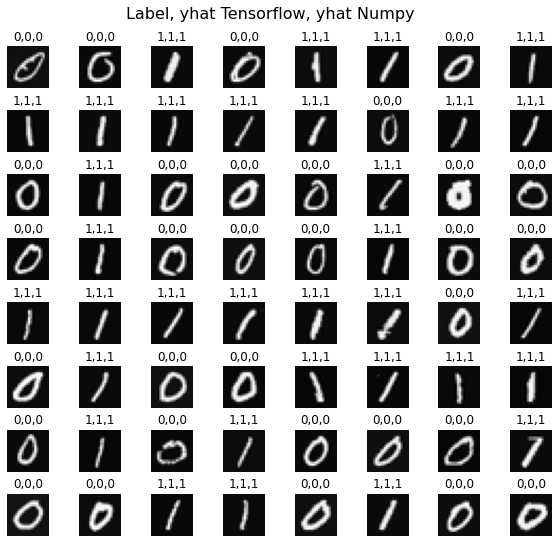

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    tf_yhat = int(tf_prediction >= 0.5)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

<a name="2.6"></a>
### 2.6 Vectorized NumPy Model Implementation (Optional)
The optional lectures described vector and matrix operations that can be used to speed the calculations.
Below describes a layer operation that computes the output for all units in a layer on a given input example:

<img src="images/C2_W1_VectorMatrix.PNG" width="600" height="450">

We can demonstrate this using the examples `X` and the `W1`,`b1` parameters above. We use `np.matmul` to perform the matrix multiply. Note, the dimensions of x and W must be compatible as shown in the diagram above.

In [38]:
x = X[0].reshape(-1,1)         # column vector (400,1)
z1 = np.matmul(x.T,W1) + b1    # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.

<img src="images/C2_W1_MatrixMatrix.PNG" width="600" height="450">
The full operation is $\mathbf{Z}=\mathbf{XW}+\mathbf{b}$. This will utilize NumPy broadcasting to expand $\mathbf{b}$ to $m$ rows. If this is unfamiliar, a short tutorial is provided at the end of the notebook.

<a name="ex03"></a>
### Exercise 3

Below, compose a new `my_dense_v` subroutine that performs the layer calculations for a matrix of examples. This will utilize `np.matmul()`. 

In [41]:
# UNQ_C3
# GRADED FUNCTION: my_dense_v

def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (ndarray (m,j)) : m examples, j units
    """
### START CODE HERE ### 
    Z = np.matmul(A_in,W) + b    
    A_out = g(Z)  
    
### END CODE HERE ### 
    return(A_out)

In [42]:
X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1, 3 features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

tf.Tensor(
[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]], shape=(4, 3), dtype=float64)


**Expected Output**

```
[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]
 ```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    In matrix form, this can be written in one or two lines. 
    
       Z = np.matmul of A_in and W plus b    
       A_out is g(Z)  
<details>
  <summary><font size="3" color="darkgreen"><b>Click for code</b></font></summary>

```python
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j,1)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (ndarray (m,j)) : m examples, j units
    """
    Z = np.matmul(A_in,W) + b    
    A_out = g(Z)                 
    return(A_out)
```


In [43]:
# UNIT TESTS
test_c3(my_dense_v)

All tests passed!


The following cell builds a three-layer neural network utilizing the `my_dense_v` subroutine above.

In [44]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

We can again copy trained weights and biases from Tensorflow.

In [45]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Let's make a prediction with the new model. This will make a prediction on *all of the examples at once*. Note the shape of the output.

In [46]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

TensorShape([1000, 1])

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [47]:
Yhat = (Prediction >= 0.5).numpy().astype(int)
print("predict a zero: ",Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


Run the following cell to see predictions. This will use the predictions we just calculated above. This takes a moment to run.

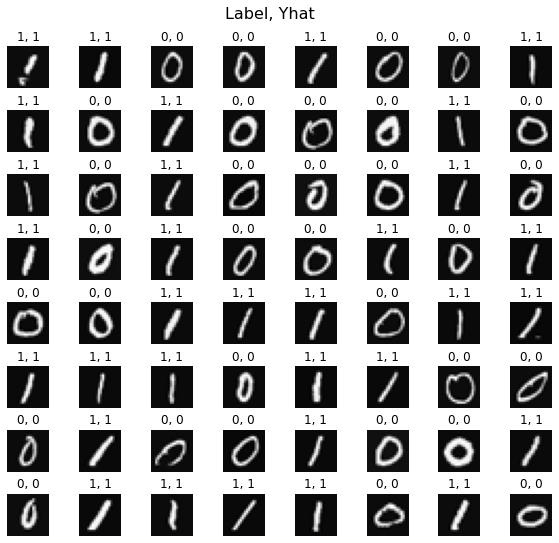

In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

You can see how one of the misclassified images looks.

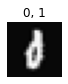

In [49]:
fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()

<a name="2.7"></a>
### 2.7 Congratulations!
You have successfully built and utilized a neural network.

<a name="2.8"></a>
### 2.8 NumPy Broadcasting Tutorial (Optional)


In the last example,  $\mathbf{Z}=\mathbf{XW} + \mathbf{b}$ utilized NumPy broadcasting to expand the vector $\mathbf{b}$. If you are not familiar with NumPy Broadcasting, this short tutorial is provided.

$\mathbf{XW}$  is a matrix-matrix operation with dimensions $(m,j_1)(j_1,j_2)$ which results in a matrix with dimension  $(m,j_2)$. To that, we add a vector $\mathbf{b}$ with dimension $(1,j_2)$.  $\mathbf{b}$ must be expanded to be a $(m,j_2)$ matrix for this element-wise operation to make sense. This expansion is accomplished for you by NumPy broadcasting.

Broadcasting applies to element-wise operations.  
Its basic operation is to 'stretch' a smaller dimension by replicating elements to match a larger dimension.

More [specifically](https://NumPy.org/doc/stable/user/basics.broadcasting.html): 
When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing (i.e. rightmost) dimensions and works its way left. Two dimensions are compatible when
- they are equal, or
- one of them is 1   

If these conditions are not met, a ValueError: operands could not be broadcast together exception is thrown, indicating that the arrays have incompatible shapes. The size of the resulting array is the size that is not 1 along each axis of the inputs.

Here are some examples:

<figure>
    <center> <img src="./images/C2_W1_Assign1_BroadcastIndexes.PNG"  alt='missing' width="400"  ><center/>
    <figcaption>Calculating Broadcast Result shape</figcaption>
<figure/>

The graphic below describes expanding dimensions. Note the red text below:

<figure>
    <center> <img src="./images/C2_W1_Assign1_Broadcasting.gif"  alt='missing' width="600"  ><center/>
    <figcaption>Broadcast notionally expands arguments to match for element wise operations</figcaption>
<figure/>

The graphic above shows NumPy expanding the arguments to match before the final operation. Note that this is a notional description. The actual mechanics of NumPy operation choose the most efficient implementation.

For each of the following examples, try to guess the size of the result before running the example.

In [ ]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

Note that this applies to all element-wise operations:

In [ ]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

<figure>
    <img src="./images/C2_W1_Assign1_VectorAdd.PNG"  alt='missing' width="740" >
    <center><figcaption><b>Row-Column Element-Wise Operations</b></figcaption></center>
<figure/>

In [ ]:
a = np.array([1,2,3,4]).reshape(-1,1)
b = np.array([1,2,3]).reshape(1,-1)
print(a)
print(b)
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

This is the scenario in the dense layer you built above. Adding a 1-D vector $b$ to a (m,j) matrix.
<figure>
    <img src="./images/C2_W1_Assign1_BroadcastMatrix.PNG"  alt='missing' width="740" >
    <center><figcaption><b>Matrix + 1-D Vector</b></figcaption></center>
<figure/>